In [2]:
from typing import Annotated, TypedDict, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage

In [3]:
load_dotenv()
llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}

In [6]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

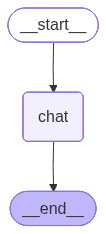

In [7]:
app

In [8]:
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [11]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='070c9d33-9438-4ef9-8c72-30e31224bd01')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='4c9435d89b4dcb21fac0fe21e7f6641f')]}

In [12]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [ ]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (yes/no): ")

In [14]:
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [15]:
print(final_result["messages"][-1].content)

Imagine you're a hiker on a mountain, and your goal is to get to the lowest point in the entire landscape (the deepest valley).

But there's a catch: you're **blindfolded** and it's super **foggy**. You can't see the whole mountain or where the valleys are.

How do you find your way down?

1.  **Feel the Ground:** You feel the ground right where you're standing.
2.  **Find the Steepest Downhill:** You figure out which direction is *most steeply downhill* from your current spot.
3.  **Take a Step:** You take one small step in that exact direction.
4.  **Repeat:** You repeat the process: Feel the new ground, find the steepest downhill, take another small step.

You keep taking these small steps until you reach a point where the ground feels flat in all directions. That means you've reached the bottom of a valley – the lowest point you can find from your starting position.

---

**Translating that to Gradient Descent:**

*   **The "Mountain Landscape"** is our **error or cost function**. 